 importing libraries

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

 loading dataset

In [8]:
df = pd.read_csv('startup data.csv')
df.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


preprocessing data 

Handling missing values & encoding categorical variables

In [9]:
drop_cols = [
    'Unnamed: 0', 'id', 'name', 'city', 'state_code',
    'state_code.1', 'object_id', 'Unnamed: 6'
]

df.drop(columns=drop_cols, inplace=True)


These columns do not help prediction (IDs, names, duplicates).

creating target variable

In [11]:
df['status'] = df['status'].map({
    'acquired': 1,
    'closed': 0
})
df = df.dropna()

selecting independent and dependent variables

In [12]:
X = df.drop('status', axis=1)
y = df['status']

SUCCESS vs FAILURE DISTRIBUTION

Shows whether dataset is imbalanced

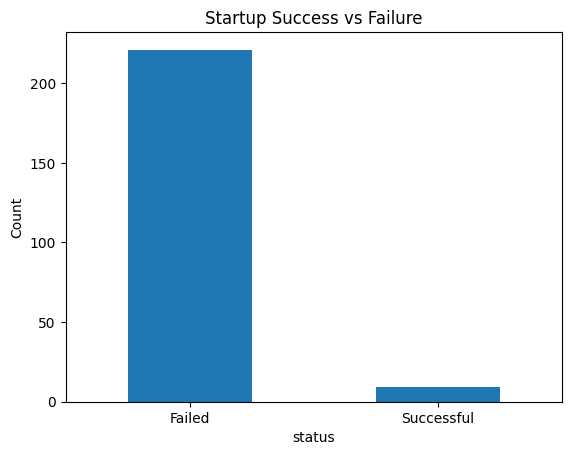

In [32]:
import matplotlib.pyplot as plt

df['status'].value_counts().plot(kind='bar')
plt.xticks([0,1], ['Failed', 'Successful'], rotation=0)
plt.title("Startup Success vs Failure")
plt.ylabel("Count")
plt.show()

FUNDING ROUNDS vs SUCCESS

Successful startups usually have more funding rounds.

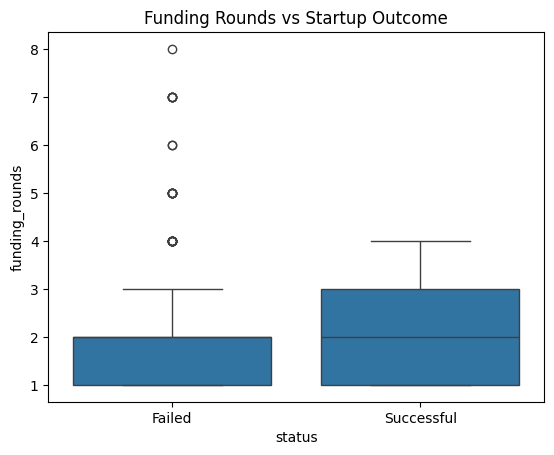

In [33]:
import seaborn as sns

sns.boxplot(x=df['status'], y=df['funding_rounds'])
plt.xticks([0,1], ['Failed', 'Successful'])
plt.title("Funding Rounds vs Startup Outcome")
plt.show()

TOTAL FUNDING vs STATUS

Higher funding correlates with higher survival chance.

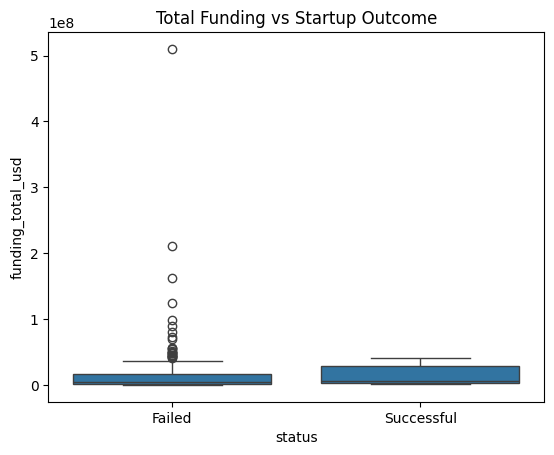

In [34]:
sns.boxplot(x=df['status'], y=df['funding_total_usd'])
plt.xticks([0,1], ['Failed', 'Successful'])
plt.title("Total Funding vs Startup Outcome")
plt.show()


TEAM SIZE vs SUCCESS

Mid-sized teams often perform better than very small teams.

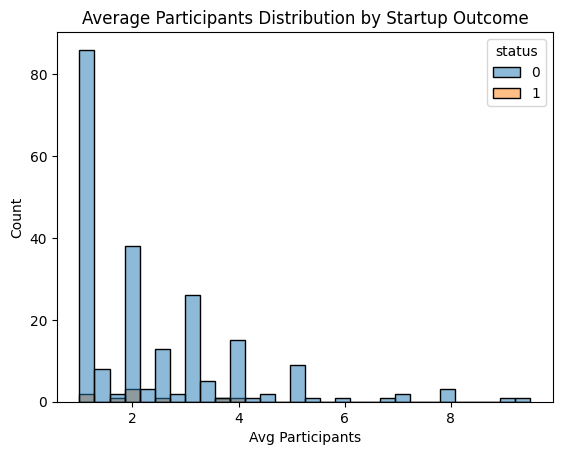

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use 'team_size' if available, otherwise fall back to 'avg_participants'
plot_col = 'team_size' if 'team_size' in df.columns else ('avg_participants' if 'avg_participants' in df.columns else None)
if plot_col is None:
    print("No suitable column found for team size plot. Tried 'team_size' and 'avg_participants'.")
else:
    sns.histplot(data=df, x=plot_col, hue='status', bins=30)
    plt.xlabel(plot_col.replace('_', ' ').title())
    title_map = {'team_size': 'Team Size', 'avg_participants': 'Average Participants'}
    plt.title(f"{title_map.get(plot_col, plot_col)} Distribution by Startup Outcome")
    plt.show()

TRAIN-TEST SPLIT

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


feature scaling

In [15]:
from sklearn.preprocessing import StandardScaler

# Keep only numeric features before scaling
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
X_train = X_train[numeric_cols]
X_test = X_test[numeric_cols]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

grid search - random forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [17]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


applying grid search

In [18]:
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'
)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

best model

In [19]:
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


evaluation

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9565217391304348
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        44
           1       0.00      0.00      0.00         2

    accuracy                           0.96        46
   macro avg       0.48      0.50      0.49        46
weighted avg       0.91      0.96      0.94        46



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


confusion matrix

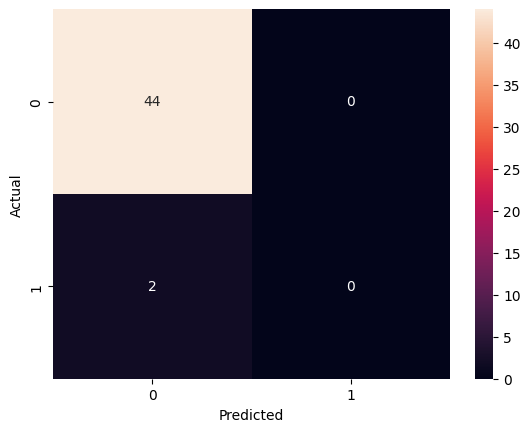

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

saving the model

In [27]:
import joblib

joblib.dump(best_model, "startup_success_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

feature importance

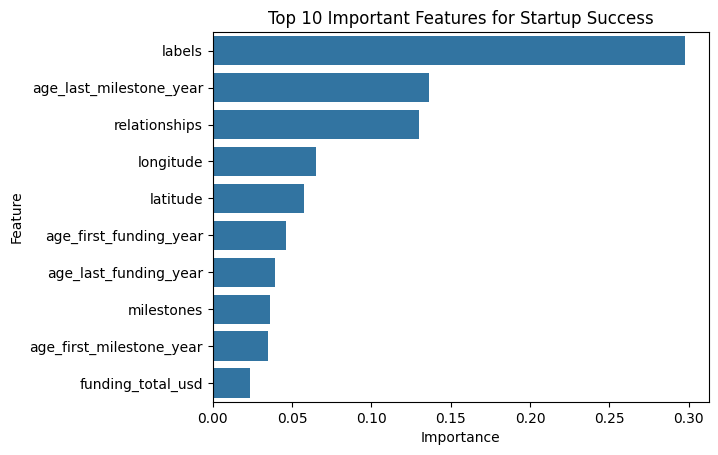

In [31]:
import pandas as pd
import numpy as np

# Use numeric feature names that match the features used for training
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
importances = best_model.feature_importances_
# Align lengths in case some preprocessing changed feature counts
min_len = min(len(numeric_cols), len(importances))
numeric_cols = numeric_cols[:min_len]
importances = importances[:min_len]

importance_df = pd.DataFrame({
    'Feature': numeric_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Top 10 Important Features for Startup Success")
plt.show()